# 微调 Fine Tune
我们还描述了学术界当下使用最广泛的大规模图像数据集ImageNet，它有超过1,000万的图像和1,000类的物体。然而，我们平常接触到数据集的规模通常在这两者之间。

假设我们想从图像中识别出不同种类的椅子，然后将购买链接推荐给用户。一种可能的方法是先找出100种常见的椅子，为每种椅子拍摄1,000张不同角度的图像，然后在收集到的图像数据集上训练一个分类模型。这个椅子数据集虽然可能比Fashion-MNIST数据集要庞大，但样本数仍然不及ImageNet数据集中样本数的十分之一。这可能会导致适用于ImageNet数据集的复杂模型在这个椅子数据集上过拟合。同时，因为数据量有限，最终训练得到的模型的精度也可能达不到实用的要求。

为了应对上述问题，一个显而易见的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资金。例如，为了收集ImageNet数据集，研究人员花费了数百万美元的研究经费。虽然目前的数据采集成本已降低了不少，但其成本仍然不可忽略。

另外一种解决办法是应用迁移学习（transfer learning），将从源数据集学到的知识迁移到目标数据集上。例如，虽然ImageNet数据集的图像大多跟椅子无关，但在该数据集上训练的模型可以抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成等。这些类似的特征对于识别椅子也可能同样有效。

本节我们介绍迁移学习中的一种常用技术：微调（fine tuning）。如图所示，微调由以下4步构成。

1 在源数据集（如ImageNet数据集）上预训练一个神经网络模型，即源模型。
2 创建一个新的神经网络模型，即目标模型。它复制了源模型上除了输出层外的所有模型设计及其参数。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
3 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
4 在目标数据集（如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。
<div align=center>
<img width="500" src="imgs/fine-tune.svg"/>
</div>
<div align=center>微调</div>

当目标数据集远小于源数据集时，微调有助于提升模型的泛化能力。

## 热狗识别

[热狗识别数据集](https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/hotdog.zip)

接下来我们来实践一个具体的例子：热狗识别。我们将基于一个小数据集对在ImageNet数据集上训练好的ResNet模型进行微调。该小数据集含有数千张包含热狗和不包含热狗的图像。我们将使用微调得到的模型来识别一张图像中是否包含热狗。

首先，导入实验所需的包或模块。torchvision的models包提供了常用的预训练模型。如果希望获取更多的预训练模型，可以使用使用pretrained-models.pytorch仓库。

In [8]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os

import sys
sys.path.append("..") 
import dl_utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

它含有1400张包含热狗的正类图像，和同样多包含其他食品的负类图像。各类的1000张图像被用于训练，其余则用于测试。

我们首先将压缩后的数据集下载到路径data_dir之下，然后在该路径将下载好的数据集解压，得到两个文件夹hotdog/train和hotdog/test。这两个文件夹下面均有hotdog和not-hotdog两个类别文件夹，每个类别文件夹里面是图像文件。

In [3]:
data_dir = 'D:/hotdog'
os.listdir(os.path.join(data_dir))

['test', 'train']

In [40]:
#我们创建两个ImageFolder实例来分别读取训练数据集和测试数据集中的所有图像文件。
train_imgs = ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'test'))

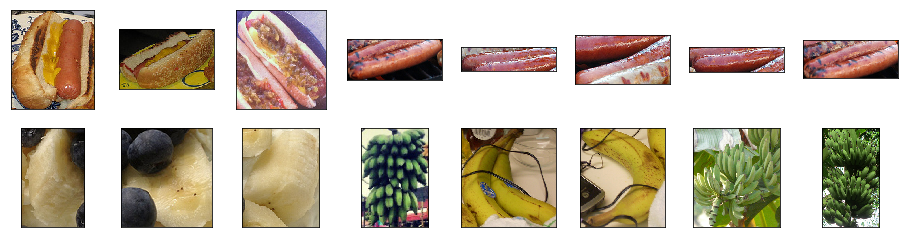

In [12]:
#下面画出前8张正类图像和最后8张负类图像。可以看到，它们的大小和高宽比各不相同。
from imp import reload
reload(dl_utils)
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
dl_utils.show_images(hotdogs + not_hotdogs, 2, 8, scale=2);

在训练时，我们先从图像中裁剪出**随机大小和随机高宽比**的一块随机区域，然后将该区域**缩放为高和宽均为224像素的输入**。测试时，我们将图像的高和宽均缩放为256像素，然后从中裁剪出高和宽均为224像素的中心区域作为输入。此外，我们对RGB（红、绿、蓝）**三个颜色通道的数值做标准化**：每个数值减去该通道所有数值的平均值，再除以该通道所有数值的标准差作为输出。

>注: 在使用预训练模型时，一定要和预训练时作同样的预处理。 如果你使用的是torchvision的models，那就要求: All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 如果你使用的是pretrained-models.pytorch仓库，请务必阅读其README，其中说明了如何预处理。

In [13]:
# 指定RGB三个通道的均值和方差来将图像通道归一化
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])

(122, 144)
(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


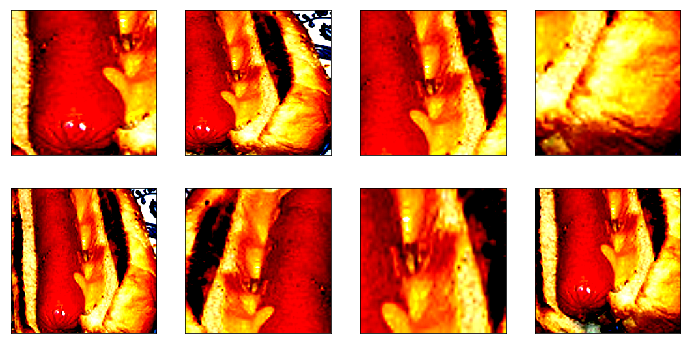

In [22]:
def apply(img, aug, num_rows=2, num_cols=4, scale=3):
    Y = [aug(img).permute(1,2,0).numpy() for _ in range(num_rows * num_cols)]
    dl_utils.show_images(Y, num_rows, num_cols, scale)
    
print(train_imgs[0][0].size)

apply(train_imgs[0][0], train_augs ,scale = 3)

## 定义和初始化模型
我们使用在ImageNet数据集上预训练的ResNet-18作为源模型。这里指定pretrained=True来自动下载并加载预训练的模型参数。在第一次使用时需要联网下载模型参数。

>不管你是使用的torchvision的models还是pretrained-models.pytorch仓库，默认都会将预训练好的模型参数下载到你的home目录下.torch文件夹。你可以通过修改环境变量 $ TORCH_MODEL_ZOO来更改下载目录: export TORCH_MODEL_ZOO="/local/pretrainedmodels 另外我比较常使用的方法是，在其源码中找到下载地址直接浏览器输入地址下载，下载好后将其放到环境变量 $ TORCH_MODEL_ZOO所指文件夹即可，这样比较快。

In [42]:
pretrained_net = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Jarvis/.cache\torch\checkpoints\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████| 46827520/46827520 [00:42<00:00, 1098932.31it/s]


下面打印源模型的成员变量fc。作为一个全连接层，它将ResNet最终的全局平均池化层输出变换成ImageNet数据集上1000类的输出。

In [43]:
print(pretrained_net.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [45]:
print(pretrained_net.named_parameters)

<bound method Module.named_parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

>注: 如果你使用的是其他模型，那可能没有成员变量fc（比如models中的VGG预训练模型），所以正确做法是查看对应模型源码中其定义部分，这样既不会出错也能加深我们对模型的理解。pretrained-models.pytorch仓库貌似统一了接口，但是我还是建议使用时查看一下对应模型的源码。

可见此时pretrained_net最后的输出个数等于目标数据集的类别数1000。所以我们应该将最后的fc成修改我们需要的输出类别数:

In [46]:
pretrained_net.fc = nn.Linear(512, 2)
print(pretrained_net.fc)

Linear(in_features=512, out_features=2, bias=True)


In [47]:
print(pretrained_net.named_parameters)

<bound method Module.named_parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

此时，pretrained_net的fc层就被随机初始化了，但是其他层依然保存着预训练得到的参数。由于是在很大的ImageNet数据集上预训练的，所以参数已经足够好，因此一般只需使用较小的学习率来微调这些参数，而fc中的随机初始化参数一般需要更大的学习率从头训练。PyTorch可以方便的对模型的不同部分设置不同的学习参数，我们在下面代码中将fc的学习率设为已经预训练过的部分的10倍。

In [57]:
list(pretrained_net.fc.parameters())

[Parameter containing:
 tensor([[ 0.0630, -0.0082, -0.0095,  ...,  0.0207,  0.0176, -0.0340],
         [-0.0502,  0.0474,  0.0670,  ..., -0.0593, -0.0167,  0.0420]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0295, -0.0316], requires_grad=True)]

In [60]:
fc_params = list(pretrained_net.fc.parameters())
torch.nn.init.xavier_normal_(fc_params[0], gain=1)


Parameter containing:
tensor([[-0.0324,  0.0213,  0.0181,  ..., -0.0270, -0.0992,  0.0250],
        [-0.1266,  0.0073,  0.0808,  ..., -0.0746, -0.0593,  0.0960]],
       requires_grad=True)

In [61]:
torch.nn.init.normal_(fc_params[1])

Parameter containing:
tensor([1.5468, 1.2335], requires_grad=True)

In [62]:
output_params = list(map(id, pretrained_net.fc.parameters()))
feature_params = filter(lambda p: id(p) not in output_params, pretrained_net.parameters())

lr = 0.01
optimizer = optim.SGD([{'params': feature_params},
                       {'params': pretrained_net.fc.parameters(), 'lr': lr * 10}],
                       lr=lr, weight_decay=0.001)

## 微调模型
我们先定义一个使用微调的训练函数train_fine_tuning以便多次调用。

In [74]:
import time
reload(dl_utils)

def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=5):
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs),
                            batch_size, shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
                           batch_size)
    loss = torch.nn.CrossEntropyLoss()
    dl_utils.train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

In [75]:
train_fine_tuning(pretrained_net, optimizer)

training on  cuda
epoch 1, loss 0.3477, train acc 0.906, test acc 0.899, time 21.9 sec
epoch 2, loss 0.1702, train acc 0.906, test acc 0.941, time 18.5 sec
epoch 3, loss 0.0524, train acc 0.951, test acc 0.920, time 18.8 sec
epoch 4, loss 0.0763, train acc 0.906, test acc 0.940, time 18.9 sec
epoch 5, loss 0.0258, train acc 0.952, test acc 0.943, time 18.5 sec


作为对比，我们定义一个相同的模型，但将它的所有模型参数都初始化为随机值。由于整个模型都需要从头训练，我们可以使用较大的学习率。

In [76]:
scratch_net = models.resnet18(pretrained=False, num_classes=2)
print(scratch_net.parameters)
lr = 0.1
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tuning(scratch_net, optimizer)

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rel

可以看到，微调的模型因为参数初始值更好，往往在相同迭代周期下取得更高的精度。

小结
迁移学习将从源数据集学到的知识迁移到目标数据集上。微调是迁移学习的一种常用技术。
目标模型复制了源模型上除了输出层外的所有模型设计及其参数，并基于目标数据集微调这些参数。而目标模型的输出层需要从头训练。
一般来说，微调参数会使用较小的学习率，而从头训练输出层可以使用较大的学习率。